In [1]:
import pandas as pd
from pandas import DataFrame, read_csv
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Import training dataset and select the features (S1-S10)

In [2]:
train = read_csv("./data/stock_train.csv")

In [3]:
train1 = train[train.columns.tolist()[1:]]

### Compute correlation between variable for data exploration

In [4]:
train1.corr()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
S1,1.000000,-0.896286,0.915067,0.845219,0.934906,0.938336,0.920357,0.627016,0.919944,-0.635897
S2,-0.896286,1.000000,-0.879798,-0.848230,-0.908228,-0.916752,-0.892510,-0.741348,-0.901114,0.680856
S3,0.915067,-0.879798,1.000000,0.841010,0.945869,0.953039,0.918501,0.656271,0.933234,-0.663276
S4,0.845219,-0.848230,0.841010,1.000000,0.896582,0.900291,0.880161,0.608569,0.910099,-0.606429
S5,0.934906,-0.908228,0.945869,0.896582,1.000000,0.988365,0.961122,0.688381,0.965143,-0.673424
S6,0.938336,-0.916752,0.953039,0.900291,0.988365,1.000000,0.965351,0.702448,0.972927,-0.686498
S7,0.920357,-0.892510,0.918501,0.880161,0.961122,0.965351,1.000000,0.725190,0.938242,-0.641339
S8,0.627016,-0.741348,0.656271,0.608569,0.688381,0.702448,0.725190,1.000000,0.637574,-0.565303
S9,0.919944,-0.901114,0.933234,0.910099,0.965143,0.972927,0.938242,0.637574,1.000000,-0.674329
S10,-0.635897,0.680856,-0.663276,-0.606429,-0.673424,-0.686498,-0.641339,-0.565303,-0.674329,1.000000


#### Visualize the matrix

In [5]:
def plot_corr(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

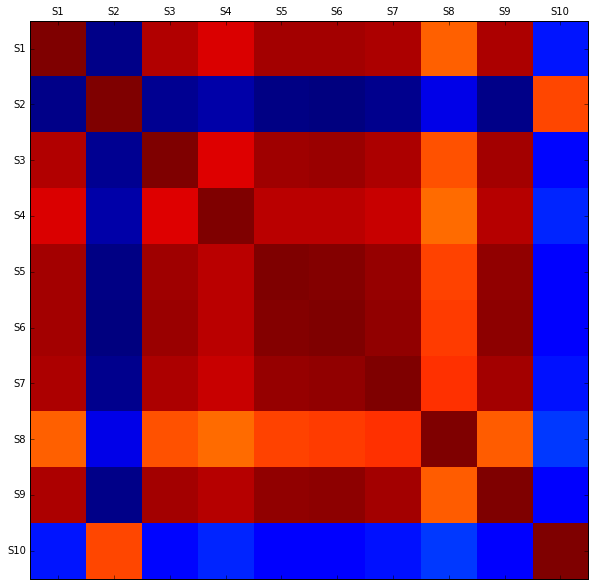

In [6]:
plot_corr(train1)

##### We can try to manually evaluate the good features using the correlation matrix but this approach does not scale well. Also lets verfiy this matrix using machine learning models. |

### We will be using 2 methods for feature selection:

### Method 1: Explicit Feature selection :

### Split the test and train set

In [7]:
#train x
x = train[train1.columns.tolist()[1:]].get_values()[:40]
#train y
y = train[train1.columns.tolist()[:1]].get_values()[:40]

y = y.reshape((y.shape[0],))

#test y
ydash = train[train1.columns.tolist()[:1]].get_values()[40:]

ydash = ydash.reshape((ydash.shape[0],))
#test x
xdash = train[train1.columns.tolist()[1:]].get_values()[40:]

#### Steps RandomForestRegressor and RFE requires y in string or int, preparation of y values for these models :

In [8]:
yprime = y

In [9]:
yprime = np.asarray(yprime, dtype="|S6")

In [10]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
model.fit(x, y)
# display the relative importance of stocks
print(model.feature_importances_)

[ 0.18486171  0.10577999  0.02642044  0.19872537  0.09949958  0.28826443
  0.00531066  0.04640495  0.04473287]


In [11]:
from sklearn.feature_selection import RFE
model = RandomForestRegressor(n_estimators=100)
# create the RFE model and select 5 attributes
rfe = RFE(model, 5)
rfe = rfe.fit(x, y)
# top 5 stocks helping in prediction of S1
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True  True  True False False False]
[1 1 4 1 1 1 5 2 3]


#### From the above 2 steps we confirm that the top 5 features which help in predicting S1 are S2, S3, S5, S6 and S7. Lets create a model based on these parameters"

##### Select features from train x and test x

In [12]:
selectx = x[:,rfe.support_]

In [13]:
selectxdash = xdash[:,rfe.support_]

### Model Used : For this regression/prediction task we would be using Epsilon-Support Vector Regression with an RBF Kernel. This model performs good with less data, in our case we have dataset of 50 data points for training. 

In [14]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

### For Parameter selection we would be using GridSearchCV method, which allows us to find the best set of parameters for a model.

In [15]:
from sklearn.grid_search import GridSearchCV

#### Lets define Parameter set

In [16]:
# Control Regularization No regularization, features already selected 
Cs = np.array([1000])
# Controls Gamma for RBF
gama = np.array([0.001, 0.002,0.005, 0.01, 0.05, 0.1, 0.5, 0.9,1])
# Epsilon penalty
eps = np.array([0.01, 0.05, 0.1, 0.5, 0.9,1])

#### Define Model :

In [17]:
clf = GridSearchCV(estimator=svr_rbf, param_grid=dict(C=Cs, gamma = gama, epsilon = eps ),n_jobs=-1, verbose = True,scoring ="mean_squared_error")

#### Fit the model

In [18]:
clf.fit(selectx,y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'epsilon': array([ 0.01,  0.05,  0.1 ,  0.5 ,  0.9 ,  1.  ]), 'C': array([1000]), 'gamma': array([ 0.001,  0.002,  0.005,  0.01 ,  0.05 ,  0.1  ,  0.5  ,  0.9  ,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=True)

#### Find the best parameters and best score

In [19]:
print (clf.best_estimator_.epsilon, clf.best_estimator_.C, clf.best_estimator_.gamma)

(0.5, 1000, 0.002)


In [20]:
print(clf.best_score_)

-0.0914123132636


#### Check the score on test data set

In [21]:
output = clf.score(selectxdash, ydash )

/Users/himanshumisra/Desktop/DataScience/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [22]:
output

-0.14938958331727686

### Predict the values using selected parametes for the model

In [23]:
svr_rbf_final = SVR(kernel='rbf', C=1000, gamma=0.002, epsilon = 0.5)

In [24]:
x1 = train[train1.columns.tolist()[1:]].get_values()

In [25]:
y1 = train[train1.columns.tolist()[:1]].get_values()

In [26]:
y1 = y1.reshape((y1.shape[0],))

### Fit the model and predict the output for the output test set

In [27]:
svr_rbf_final.fit(x1,y1)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma=0.002,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [28]:
test = read_csv("./data/stock_test.csv")

In [29]:
testx = test[test.columns.tolist()[2:]].get_values()

In [30]:
np.set_printoptions(suppress=True)

In [31]:
output_final = svr_rbf_final.predict(testx)

In [32]:
output = DataFrame(output_final, columns=["S1"])

In [33]:
output

,S1
0,-0.223873
1,1.046021
2,-0.613003
3,0.157446
4,2.120884
5,-1.032572
6,0.206245
7,0.733564
8,-0.457325
9,-1.035555


## Method 2 : Implicit Feature slection using Regularization

#### This time we use regularization to select the features automatically, most of the steps are same except we would check several values of parameter C in SVR (less value of C means more regularization) and use the best to select the regularization parameter. We are also using all the variables (S2-S10) in prediction task, unlike previous method where we selected top 5 features.

##### There would be comment in the code as most of the steps are same as before

In [34]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

from sklearn.grid_search import GridSearchCV

Cs = np.array([0.01, 0.05, 0.1, 0.5, 0.9,1])

gama = np.array([0.001, 0.002,0.005, 0.01, 0.05, 0.1, 0.5, 0.9,1])

eps = np.array([0.01, 0.05, 0.1, 0.5, 0.9,1])

Cs

clf = GridSearchCV(estimator=svr_rbf, param_grid=dict(C=Cs, gamma = gama, epsilon = eps ),n_jobs=-1, verbose = True,scoring ="mean_squared_error")

dict(C=Cs, d= Cs)

x = train[train1.columns.tolist()[1:]].get_values()[:40]

y = train[train1.columns.tolist()[:1]].get_values()[:40]

y = y.reshape((y.shape[0],))

ydash = train[train1.columns.tolist()[:1]].get_values()[40:]

ydash = ydash.reshape((ydash.shape[0],))

xdash = train[train1.columns.tolist()[1:]].get_values()[40:]

In [35]:
clf.fit(x,y)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:    1.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'epsilon': array([ 0.01,  0.05,  0.1 ,  0.5 ,  0.9 ,  1.  ]), 'C': array([ 0.01,  0.05,  0.1 ,  0.5 ,  0.9 ,  1.  ]), 'gamma': array([ 0.001,  0.002,  0.005,  0.01 ,  0.05 ,  0.1  ,  0.5  ,  0.9  ,  1.   ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=True)

In [36]:
print(clf.best_estimator_.epsilon,clf.best_estimator_.C,clf.best_estimator_.gamma)
print(clf.best_score_)

(0.01, 1.0, 0.002)
-0.148732577648


In [37]:
output = clf.score(xdash, ydash )

In [38]:
output

-0.11518836074749816

In [39]:
svr_rbf_final = SVR(kernel='rbf', C=1, gamma=0.002, epsilon = 0.01)

In [40]:
x1 = train[train1.columns.tolist()[1:]].get_values()

In [41]:
y1 = train[train1.columns.tolist()[:1]].get_values()

In [42]:
y1 = y1.reshape((y1.shape[0],))

In [43]:
svr_rbf_final.fit(x1,y1)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=0.002,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [44]:
test = read_csv("./data/stock_test.csv")

In [45]:
testx = test[test.columns.tolist()[2:]].get_values()

In [46]:
np.set_printoptions(suppress=True)

In [47]:
output_final = svr_rbf_final.predict(testx)

In [48]:
output = DataFrame({"Date":test[test.columns.tolist()[0]].get_values(), "Value":output_final})

In [49]:
output

,Date,Value
0,8/11/14 0:00,-0.238854
1,8/12/14 0:00,0.887702
2,8/13/14 0:00,-0.710510
3,8/14/14 0:00,0.000367
4,8/15/14 0:00,1.853807
5,8/18/14 0:00,-1.126579
6,8/19/14 0:00,-0.081980
7,8/20/14 0:00,0.545631
8,8/21/14 0:00,-0.459528
9,8/22/14 0:00,-1.110085


### Final Method selection

####  Using the model generated using Regularization for final output as it is generalizing well

In [50]:
output.to_csv("prediction.csv")